In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import torch
# from heat_solver import solve_heat_equation
from heat_solver import HeatSolver
from utils import (
    verification_solution, verification_source, compute_l2_error, 
    compute_relative_error, visualize_solution, visualize_comparison, plot_convergence_analysis,
    print_solver_info, create_conductivity_field
)

import matplotlib.pyplot as plt

In [2]:
device = 'cpu'

In [5]:
%%time
# Create conductivity field
M = 10
sigma = create_conductivity_field(M, pattern='constant')
sigma.requires_grad_(True)

solver = HeatSolver(sigma, M, verification_source, device)

# Solve heat equation
u_final, u_b_history = solver(T=1.0, max_sigma=5)

print(f"Final temperature range: [{u_final.min():.4f}, {u_final.max():.4f}]")

Final temperature range: [-0.6216, 0.6216]
CPU times: total: 7.19 s
Wall time: 6.99 s


In [50]:
h = 1.0 / M
x = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
y = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
X, Y = torch.meshgrid(x, y, indexing='ij')

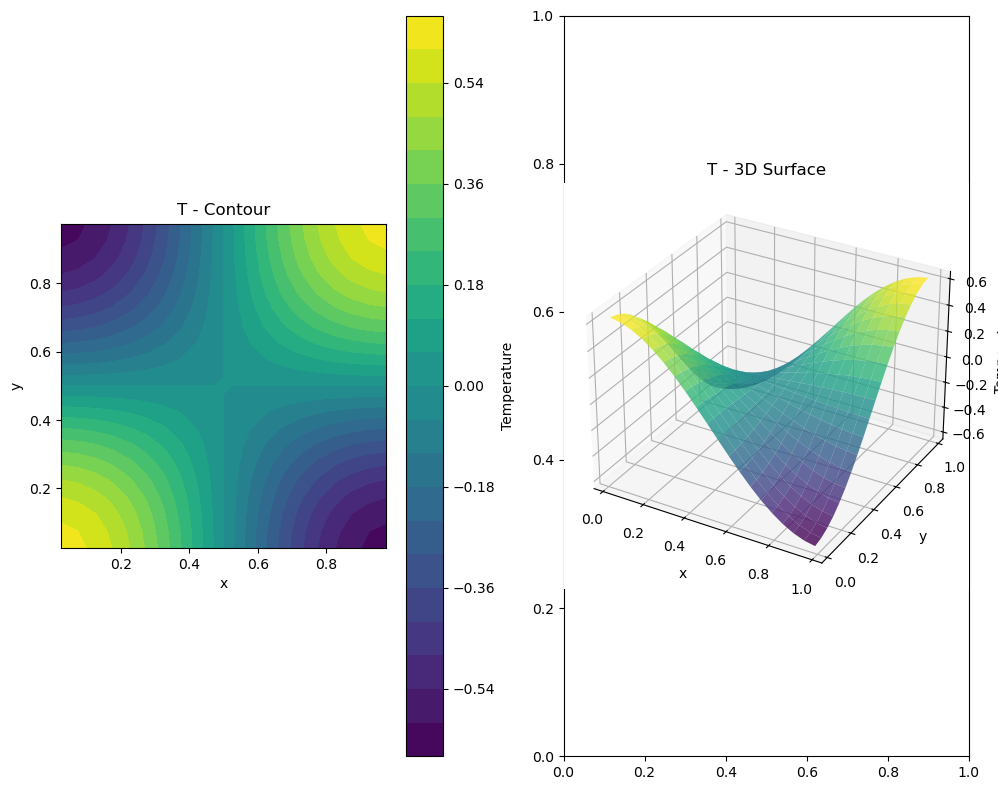

In [51]:
visualize_solution(u_final.detach().numpy(), X.detach().numpy(), Y.detach().numpy(), "T")

In [6]:
from inverse_solver import InverseSolver

In [7]:
u_final.shape

torch.Size([10, 10])

In [8]:
u_b_history.shape

torch.Size([4001, 36])

In [13]:
inv_solver = InverseSolver(
    M,
    u_b_history.detach(),
    verification_source,
    n_steps=u_b_history.shape[0] - 1,
    alpha=0.001,
    sigma_0=2,
    device=device,
)

In [14]:
final_sigma, total_loss_history, boundary_loss_history, regularization_loss_history = inv_solver.solve(max_iters=20, lr=0.1)

  5%|▌         | 1/20 [00:12<03:59, 12.58s/it]

Iter 0: Loss = 0.062983


 10%|█         | 2/20 [00:24<03:40, 12.25s/it]

Iter 1: Loss = 0.056347


 15%|█▌        | 3/20 [00:36<03:27, 12.22s/it]

Iter 2: Loss = 0.049445


 20%|██        | 4/20 [00:49<03:17, 12.35s/it]

Iter 3: Loss = 0.042301


 25%|██▌       | 5/20 [01:02<03:07, 12.50s/it]

Iter 4: Loss = 0.034972


 30%|███       | 6/20 [01:15<02:57, 12.66s/it]

Iter 5: Loss = 0.027557


 35%|███▌      | 7/20 [01:27<02:42, 12.52s/it]

Iter 6: Loss = 0.020229


 40%|████      | 8/20 [01:38<02:25, 12.09s/it]

Iter 7: Loss = 0.013283


 45%|████▌     | 9/20 [01:50<02:12, 12.08s/it]

Iter 8: Loss = 0.007199


 50%|█████     | 10/20 [02:05<02:08, 12.87s/it]

Iter 9: Loss = 0.002740


 50%|█████     | 10/20 [02:17<02:17, 13.79s/it]

Converged at iteration 10, loss: 0.000993


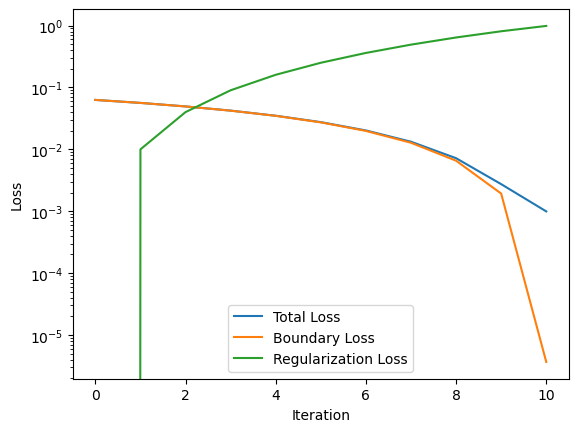

In [15]:
plt.plot(total_loss_history, label='Total Loss')
plt.plot(boundary_loss_history, label='Boundary Loss')
plt.plot(regularization_loss_history, label='Regularization Loss')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
final_sigma

array([[0.9234618 , 0.9193593 , 0.9184725 , 0.9181851 , 0.91808516,
        0.91808516, 0.91818523, 0.9184725 , 0.9193593 , 0.9234618 ],
       [0.9193593 , 0.9186654 , 0.91863286, 0.918698  , 0.91875136,
        0.91875124, 0.918698  , 0.918633  , 0.9186654 , 0.9193593 ],
       [0.9184725 , 0.91863286, 0.9190297 , 0.9195776 , 0.9200437 ,
        0.92004365, 0.9195776 , 0.91902995, 0.918633  , 0.91847265],
       [0.9181851 , 0.918698  , 0.9195776 , 0.9213308 , 0.92422664,
        0.92422664, 0.9213308 , 0.9195776 , 0.918698  , 0.91818523],
       [0.9180852 , 0.91875124, 0.9200437 , 0.92422676, 0.9613113 ,
        0.96131116, 0.9242267 , 0.92004365, 0.91875124, 0.91808516],
       [0.91808516, 0.91875124, 0.92004365, 0.92422664, 0.96131134,
        0.961311  , 0.9242267 , 0.92004365, 0.91875136, 0.91808516],
       [0.91818523, 0.918698  , 0.9195776 , 0.9213308 , 0.9242269 ,
        0.92422676, 0.9213308 , 0.9195776 , 0.918698  , 0.9181851 ],
       [0.91847265, 0.91863286, 0.9190299

In [7]:
from test_solver import *

Testing Heat Solver Accuracy
Solving heat equation...
N time steps 889
Grid: 10x10, Time step: 0.001125, Steps: 889
L2 Error: 0.002536
Relative Error: 0.008024
HEAT SOLVER INFORMATION
Grid size: 10 x 10
Grid spacing: h = 0.1000
Total time: T = 1.0
Time step: τ = 0.001124
Number of steps: 890
Maximum conductivity: σ_max = 1.0000
Stability limit: τ_max = 0.002500
CFL number: 0.4494


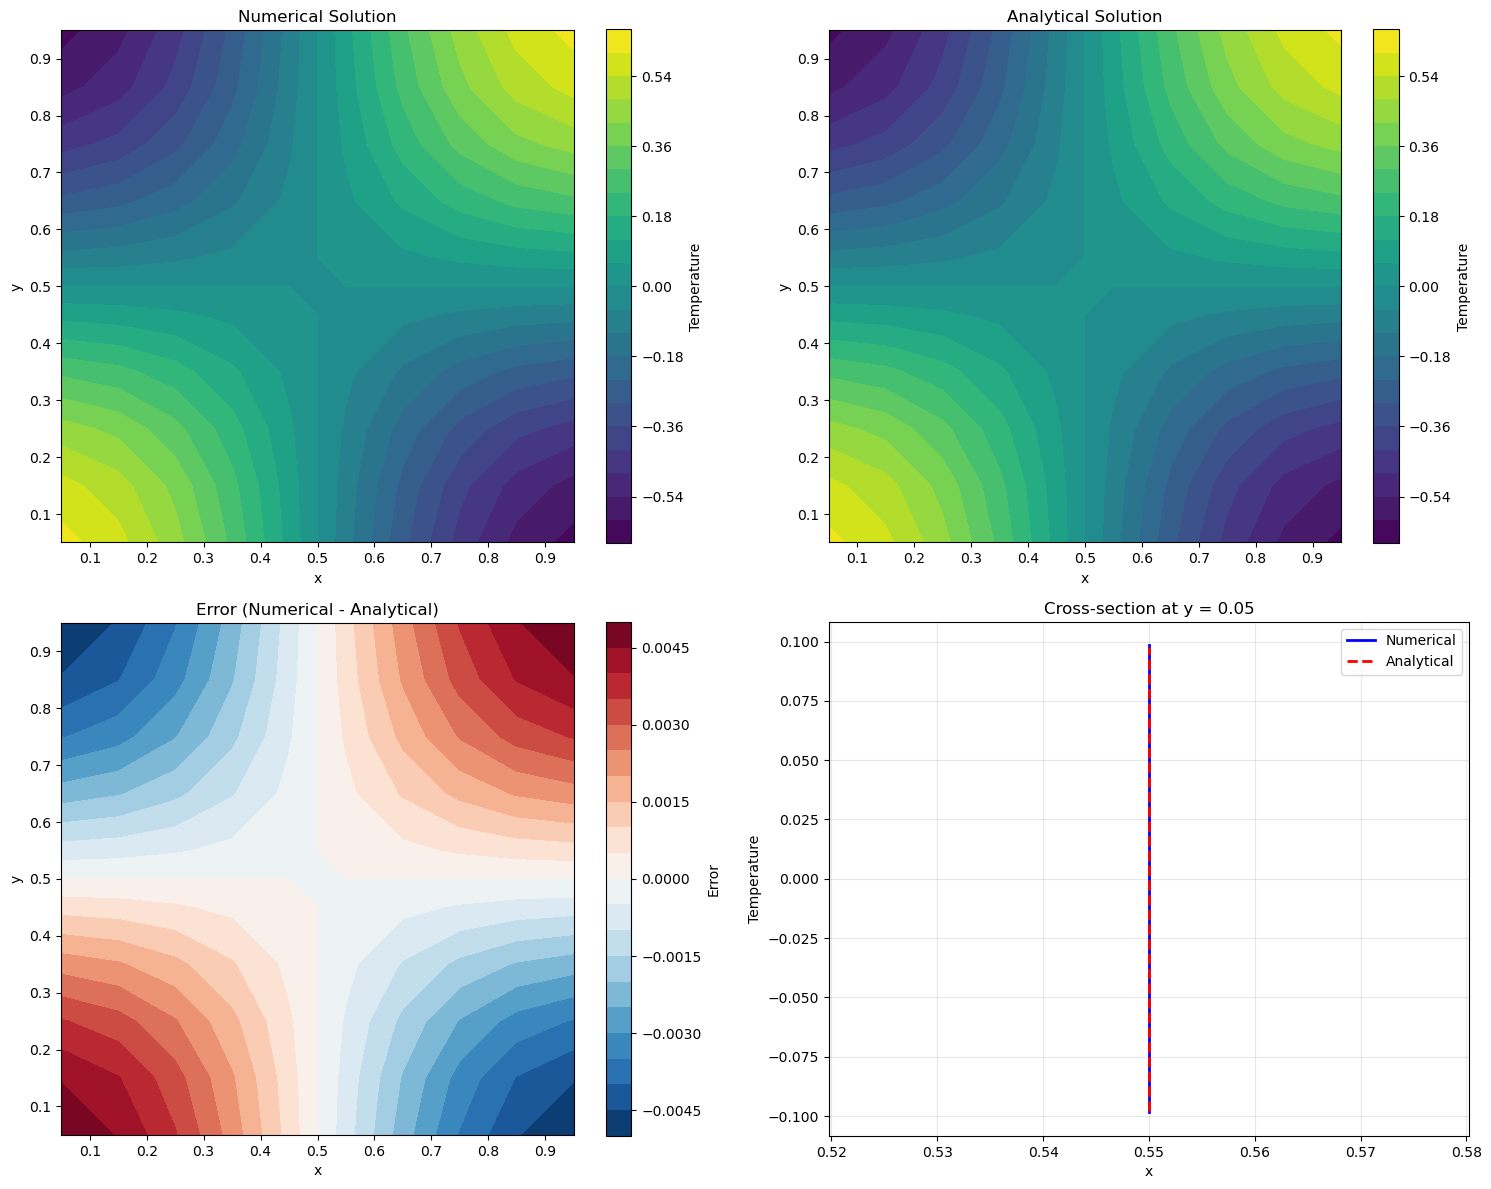

In [8]:
l2_error, relative_error = test_solver_accuracy()

In [9]:
print(f"L2 Error: {l2_error:.6f}, Relative Error: {relative_error:.6f}")

L2 Error: 0.002536, Relative Error: 0.008024



Testing Convergence Rate
Testing M = 5...
N time steps 223
Grid: 5x5, Time step: 0.004484, Steps: 223
  h = 0.2000, Error = 0.010289
Testing M = 10...
N time steps 889
Grid: 10x10, Time step: 0.001125, Steps: 889
  h = 0.1000, Error = 0.002536
Testing M = 20...
N time steps 3556
Grid: 20x20, Time step: 0.000281, Steps: 3556
  h = 0.0500, Error = 0.000632
Testing M = 40...
N time steps 14223
Grid: 40x40, Time step: 0.000070, Steps: 14223
  h = 0.0250, Error = 0.000157


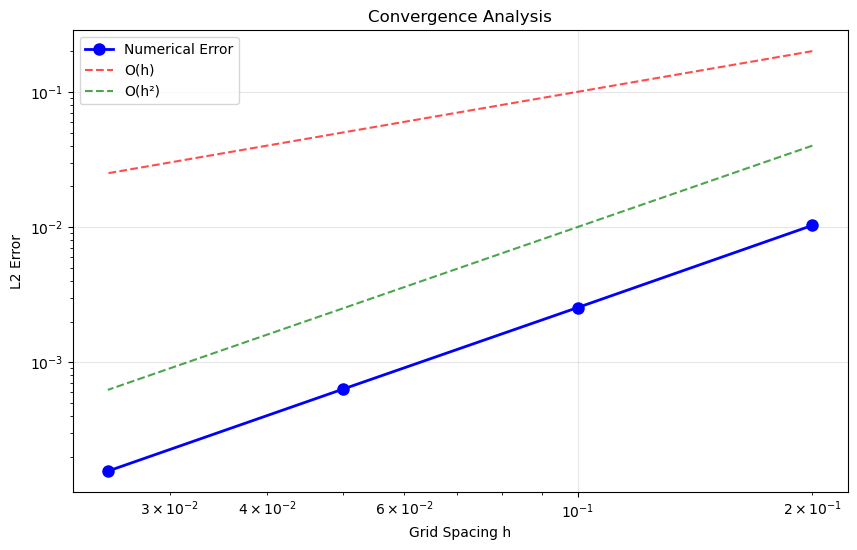

Convergence rate: 2.01


In [10]:
h_values, errors = test_convergence()